## Comparing 3 Deep Neural Networks Trained to Predict a Stocks Closing Price

### Can you teach a deep neural network (dnn) to predict a stock's closing price?

This notebook compares 3 dnn's trained to predict a stock's closing price from an algorithm's backtest trading history to see how smart you can make a dnn.

This notebook examines:

1. Which [activation function **ReLU** vs **Sigmoid**](https://keras.io/activations/) is better?
2. If preprocessing the input trading history dataset using a [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler) leads to better predictions and less errors?

### Let's take a look!

#### Background

This notebook was created using many custom indicators and the [Analysis Engine](https://github.com/AlgoTraders/stock-analysis-engine). It enables a user to roll new, custom AI training datasets from minute-by-minute, intraday algorithm backtests. Each algorithm backtest creates and publishes its trading history to S3 (Minio or AWS). These trading histories are compressed [pandas DataFrames](http://pandas.pydata.org/pandas-docs/stable/reference/frame.html) where the algorithm's indicator decisions are stored as columns within the trading history's DataFrame. These columns become training features for a dnn to learn and hopefully make better predictions than the **control** dnn.

### How it works

#### Before Running the Notebook

1. Run through [Getting Started with the Analysis Engine](https://github.com/AlgoTraders/stock-analysis-engine#getting-started)

1. [Publish a Trading History from an Algorithm's Backtest to S3](https://github.com/AlgoTraders/stock-analysis-engine#run-a-local-backtest-and-publish-algorithm-trading-history-to-s3)

```
ae -t SPY -p s3://algohistory/algo_training_SPY.json
```

#### Getting Started

1. Load the Runtime

1. Set Training Parameters

1. Load the Trading History from S3

1. Prepare Training Datasets from Trading History
   
   - Prepare a **control** dataset without any preprocessing and only use the **high** + **low** + **open** columns (3 wide) to predict the **close**
   - Prepare a **test** dataset using a MinMaxScaler with all numeric columns (895 wide) to predict the **close**

1. Create the Training Dataset Splits

1. Build and Compile 3 KerasRegressors using Keras + Tensorflow + Scikit-learn

    - Create **control** DNN without a MinMaxScaler
    - Create **test-relu** DNN with MinMaxScaler with **ReLU** activation
    - Create **test-sigmoid** DNN with MinMaxScaler with **Sigmoid** activation

1. Fit (train)

    - Fit **control** dataset (3 columns wide) with **control** DNN
    - Fit **test** dataset (895 columns wide) with **test-relu** DNN
    - Fit **test** dataset (895 columns wide) with **test-sigmoid** DNN

1. Determine Errors (MSE + MAE + MAPE + CP)

1. Run Predictions

1. Plot Historical Close vs DNNs' Predicted Close 

## Load Runtime

In [1]:
import datetime

print(f'starting - {datetime.datetime.now()}')

import copy
import numpy as np
import numpy.random as np_random
import pandas as pd
import pandas.api.types as pandas_types
import sklearn.model_selection as tt_split
import keras.wrappers.scikit_learn as keras_scikit
import tensorflow as tf
import analysis_engine.consts as ae_consts
import analysis_engine.load_history_dataset as load_history
import analysis_engine.ai.build_regression_dnn as build_dnn
import analysis_engine.ai.build_datasets_using_scalers as build_scaler_datasets
import analysis_engine.ai.build_scaler_dataset_from_df as build_scaler_df
import analysis_engine.ai.plot_dnn_fit_history as plot_fit_history
import analysis_engine.plot_trading_history as plot_trading_history

print(f'imports done - {datetime.datetime.now()}')

# ensure reproducible results tip from:
# https://machinelearningmastery.com/reproducible-results-neural-networks-keras/
np_random.seed(1)

print(f'ready - {datetime.datetime.now()}')

starting - 2019-01-28 18:50:52.779997


Using TensorFlow backend.


imports done - 2019-01-28 18:50:55.819923
ready - 2019-01-28 18:50:55.822446


## Set Training Parameters

In [2]:
predict_feature = 'close'
use_epochs = 20
use_batch_size = 10
use_test_size = 0.1
use_random_state = 1
use_seed = 7
use_shuffle = False
model_verbose = True
control_fit_verbose = False
relu_fit_verbose = False
sigmoid_fit_verbose = False

## Set Algorithm's S3 Bucket and Key Values

In [3]:
# change these to your values:
s3_bucket = (
    f'algohistory')
s3_key = (
    f'algo_training_SPY.json')

s3_access_key = ae_consts.S3_ACCESS_KEY
s3_secret_key = ae_consts.S3_SECRET_KEY
s3_region_name = ae_consts.S3_REGION_NAME
s3_address = ae_consts.S3_ADDRESS
s3_secure = ae_consts.S3_SECURE
compress = True
created_on = (
    datetime.datetime.now().strftime(
        ae_consts.COMMON_TICK_DATE_FORMAT))

## Load the Trading History from S3

In [4]:
load_res = load_history.load_history_dataset(
    s3_key=s3_key,
    s3_address=s3_address,
    s3_bucket=s3_bucket,
    s3_access_key=s3_access_key,
    s3_secret_key=s3_secret_key,
    s3_region_name=s3_region_name,
    s3_secure=s3_secure,
    compress=compress)

ticker = None
if 'tickers' not in load_res:
    print(
        f'unable to load trading history from s3://{s3_address}/{s3_bucket}/{s3_key}')
else:
    tickers = load_res.get(
        'tickers',
        [
            'SPY',
        ])
    ticker = tickers[0]
    print(
        f'loaded trading history from s3://{s3_bucket}/{s3_key}')

loaded trading history from s3://algohistory/algo_training_SPY.json


## Prepare Training Datasets from Trading History

In [5]:
df = load_res[ticker]
df['date'] = pd.to_datetime(
    df['date'])
df['minute'] = pd.to_datetime(
    df['minute'])
df_filter = (df['close'] >= 0.1)
ticker = df['ticker'].iloc[0]
first_date = df['date'].iloc[0]
end_date = df['date'].iloc[-1]

if 'minute' in df:
    found_valid_minute = df['minute'].iloc[0]
    if found_valid_minute:
        first_date = df['minute'].iloc[0]
        end_date = df['minute'].iloc[-1]

date_str = (
    f'Dates: {df[df_filter]["minute"].iloc[0]} '
    f'to '
    f'{df[df_filter]["minute"].iloc[-1]}')
    
num_rows = len(df.index)

print(
    f'prepared training data from history {s3_bucket}@{s3_key} '
    f'rows={num_rows} '
    f'dates: {first_date} to {end_date}')

predict_feature = 'close'
control_train_features = [
    'high',
    'low',
    'open'
]
control_all_features = [
    predict_feature
] + control_train_features

all_features = [
    predict_feature
]
train_features = []
for c in df.columns.values:
    if pandas_types.is_numeric_dtype(df[c]) and c not in train_features:
        if c != predict_feature:
            train_features.append(c)
        if c not in all_features:
            all_features.append(c)

features_and_minute = [
    'minute'
] + all_features
num_control_features = len(control_train_features)
num_features = len(train_features)

print(
    f'control dnn num features={num_control_features}')
print(
    f'test dnn num features={num_features}')
print(
    f'predicting: {predict_feature} from trading history with rows={len(df.index)}')

prepared training data from history algohistory@algo_training_SPY.json rows=396 dates: 2019-01-18 16:00:00 to 2019-01-28 15:59:00
control dnn num features=3
test dnn num features=895
predicting: close from trading history with rows=396


### Build Numeric Datasets from Features

In [6]:
print(
    f'converting rows={len(df[df_filter].index)} to float32 data')
timeseries_df = df[df_filter].fillna(-10000.0)
converted_df = timeseries_df[all_features].astype('float32')

print(
    f'building control train and test dfs from subset of features')
control_train_df = converted_df[control_train_features].copy()
control_test_df = converted_df[[predict_feature]].copy()
print(
    f'control train rows={len(control_train_df.index)} and test rows={len(control_test_df.index)} test columns={control_test_df.columns.values}')

train_df = None
test_df = None
x_train = None
x_test = None
y_train = None
y_test = None
scaler_predictions = None

print(
    f'building test scaler datasets for relu and sigmoid dnns')
scaler_res = build_scaler_datasets.build_datasets_using_scalers(
    train_features=train_features,
    test_feature=predict_feature,
    df=converted_df,
    test_size=use_test_size,
    seed=use_seed)
if scaler_res['status'] != ae_consts.SUCCESS:
    print(
        'failed to build scaler train and test datasets for relu and sigmoid dnns')
else:
    train_df = scaler_res['scaled_train_df']
    test_df = scaler_res['scaled_test_df']
    x_train = scaler_res['x_train']
    x_test = scaler_res['x_test']
    y_train = scaler_res['y_train']
    y_test = scaler_res['y_test']
    scaler_predictions = scaler_res['scaler_test']
    
    print(
        f'scaler train rows={len(train_df)} and test rows={len(test_df)}')

converting rows=390 to float32 data
building control train and test dfs from subset of features
control train rows=390 and test rows=390 test columns=['close']
building test scaler datasets for relu and sigmoid dnns
scaler train rows=390 and test rows=390


### Build Prediction Records

In [7]:
# on production use newly fetched pricing data not the training data
control_predict_records = converted_df[control_train_features]
predict_records = []
prediction_res = build_scaler_df.build_scaler_dataset_from_df(
    df=converted_df[train_features])
if prediction_res['status'] == ae_consts.SUCCESS:
    predict_records = prediction_res['df']
    print(
        f'Prediction scaler_rows={len(predict_records)} control={len(control_predict_records)}')
else:
    print(
        f'failed building scaled prediction records')

Prediction scaler_rows=390 control=390


### Create Deep Neural Network Configs - Control + Relu + Sigmoid

In [8]:
dnn_config = {
    'layers': [
        {
            'num_neurons': 150,
            'init': 'uniform',
            'activation': 'relu'
        },
        {
            'num_neurons': 100,
            'init': 'uniform',
            'activation': 'relu'
        },
        {
            'num_neurons': 50,
            'init': 'uniform',
            'activation': 'relu'
        },
        {
            'num_neurons': 1,
            'init': 'uniform',
            'activation': 'relu'
        }
    ]
}

dnn_relu_config = copy.deepcopy(dnn_config)
dnn_sigmoid_config = copy.deepcopy(dnn_config)
dnn_sigmoid_config['layers'][-1]['activation'] = 'sigmoid'

### Create Keras Compile Config

In [9]:
compile_config = {
    'loss': 'mse',
    'optimizer': 'adam',
    'metrics': [
        'accuracy',
        'mse',
        'mae',
        'mape',
        'cosine'
    ]
}

## Build and Compile a KerasRegressors using Keras + Tensorflow + Scikit-learn

### Build Control DNN with ReLU Activation Function

In [10]:
def set_control_model():
    return build_dnn.build_regression_dnn(
        num_features=num_control_features,
        compile_config=compile_config,
        model_config=dnn_config)

dnn_control_estimator = keras_scikit.KerasRegressor(
    build_fn=set_control_model,
    epochs=use_epochs,
    batch_size=use_batch_size,
    verbose=model_verbose)

### Build Test DNN with ReLU Activation Function

In [11]:
def set_relu_model():
    return build_dnn.build_regression_dnn(
        num_features=num_features,
        compile_config=compile_config,
        model_config=dnn_relu_config)

dnn_relu_estimator = keras_scikit.KerasRegressor(
    build_fn=set_relu_model,
    epochs=use_epochs,
    batch_size=use_batch_size,
    verbose=model_verbose)

### Build Test DNN with Sigmoid Activation Function

In [12]:
def set_sigmoid_model():
    return build_dnn.build_regression_dnn(
        num_features=num_features,
        compile_config=compile_config,
        model_config=dnn_sigmoid_config)

dnn_sigmoid_estimator = keras_scikit.KerasRegressor(
    build_fn=set_sigmoid_model,
    epochs=use_epochs,
    batch_size=use_batch_size,
    verbose=model_verbose)

## Create the Training Dataset Splits

### Create the Control Training Dataset

In [13]:
(control_x_train,
 control_x_test,
 control_y_train,
 control_y_test) = tt_split.train_test_split(
     control_train_df,
     control_test_df,
     test_size=use_test_size,
     random_state=use_random_state)

print(
    f'control train_colums={control_train_df.columns.values} test_column={control_test_df.columns.values}')

print(
    f'control data split breakdown - '
    f'x_train={len(control_x_train)} '
    f'x_test={len(control_x_test)} '
    f'y_train={len(control_y_train)} '
    f'y_test={len(control_y_test)}')

control train_colums=['high' 'low' 'open'] test_column=['close']
control data split breakdown - x_train=351 x_test=39 y_train=351 y_test=39


### Create the Training Scaler Datasets for the Relu and Sigmoid DNNs

In [14]:
(x_train,
 x_test,
 y_train,
 y_test) = tt_split.train_test_split(
     train_df,
     test_df,
     test_size=use_test_size,
     random_state=use_random_state)

print(
    f'relu and sigmoid train_colums={len(train_features)} test_column={predict_feature}')

print(
    f'training data split breakdown relu and sigmoid - '
    f'x_train={len(x_train)} '
    f'x_test={len(x_test)} '
    f'y_train={len(y_train)} '
    f'y_test={len(y_test)}')

relu and sigmoid train_colums=895 test_column=close
training data split breakdown relu and sigmoid - x_train=351 x_test=39 y_train=351 y_test=39


## Fit the Control DNN

In [15]:
print(
    f'control - fitting estimator - '
    f'predicting={predict_feature} '
    f'epochs={use_epochs} '
    f'batch={use_batch_size} '
    f'test_size={use_test_size} '
    f'seed={use_seed}')
    
control_history = dnn_control_estimator.fit(
    control_x_train,
    control_y_train,
    validation_data=(
        control_x_train,
        control_y_train),
    epochs=use_epochs,
    batch_size=use_batch_size,
    shuffle=use_shuffle,
    verbose=control_fit_verbose)

control - fitting estimator - predicting=close epochs=20 batch=10 test_size=0.1 seed=7


## Fit the Test ReLU DNN

In [16]:
print(
    f'relu - fitting estimator - '
    f'predicting={predict_feature} '
    f'epochs={use_epochs} '
    f'batch={use_batch_size} '
    f'test_size={use_test_size} '
    f'seed={use_seed}')

relu_history = dnn_relu_estimator.fit(
    x_train,
    y_train,
    validation_data=(
        x_train,
        y_train),
    epochs=use_epochs,
    batch_size=use_batch_size,
    shuffle=use_shuffle,
    verbose=relu_fit_verbose)

relu - fitting estimator - predicting=close epochs=20 batch=10 test_size=0.1 seed=7


## Fit the Test Sigmoid DNN

In [17]:
print(
    f'sigmoid - fitting estimator - '
    f'predicting={predict_feature} '
    f'epochs={use_epochs} '
    f'batch={use_batch_size} '
    f'test_size={use_test_size} '
    f'seed={use_seed}')

sigmoid_history = dnn_sigmoid_estimator.fit(
    x_train,
    y_train,
    validation_data=(
        x_train,
        y_train),
    epochs=use_epochs,
    batch_size=use_batch_size,
    shuffle=use_shuffle,
    verbose=sigmoid_fit_verbose)

sigmoid - fitting estimator - predicting=close epochs=20 batch=10 test_size=0.1 seed=7


## Determine Errors (MSE + MAE + MAPE + CP)

### Determine Control Errors

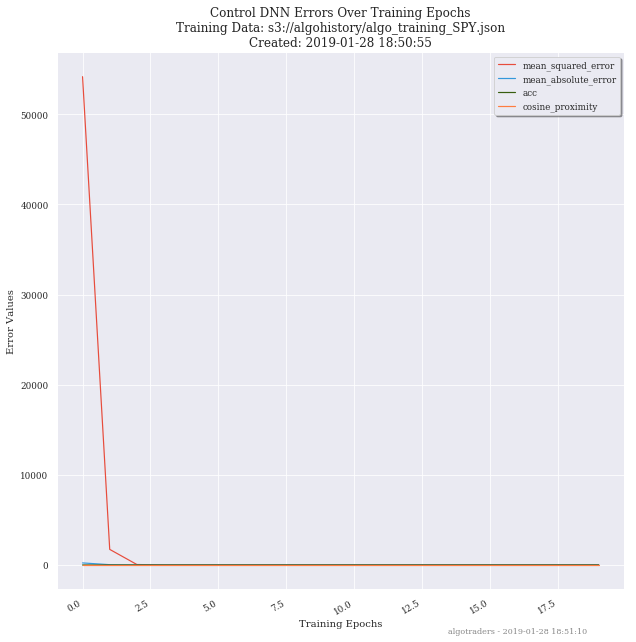

In [18]:
plot_res = plot_fit_history.plot_dnn_fit_history(
    df=control_history.history,
    title=(
        f'Control DNN Errors Over Training Epochs\n'
        f'Training Data: s3://{s3_bucket}/{s3_key}\n'
        f'Created: {created_on}'),
    red='mean_squared_error',
    blue='mean_absolute_error',
    green='acc',  # accuracy
    orange='cosine_proximity')

### Determine ReLU Errors

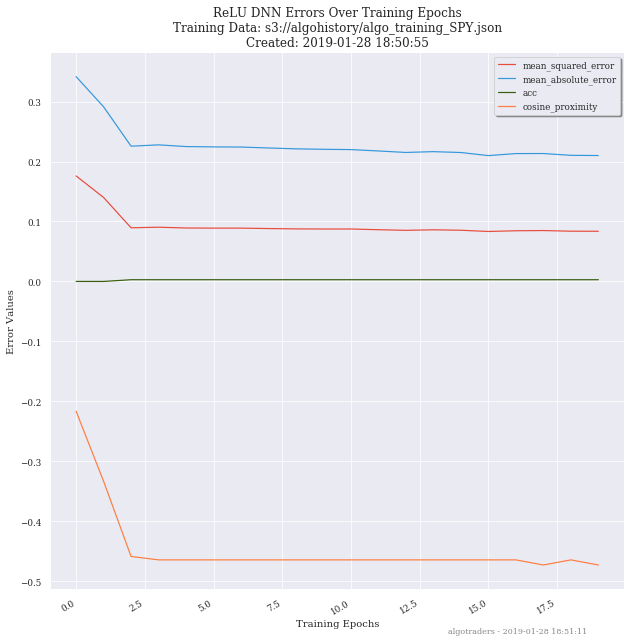

In [19]:
plot_res = plot_fit_history.plot_dnn_fit_history(
    df=relu_history.history,
    title=(
        f'ReLU DNN Errors Over Training Epochs\n'
        f'Training Data: s3://{s3_bucket}/{s3_key}\n'
        f'Created: {created_on}'),
    red='mean_squared_error',
    blue='mean_absolute_error',
    green='acc',  # accuracy
    orange='cosine_proximity')

### Determine Sigmoid Errors

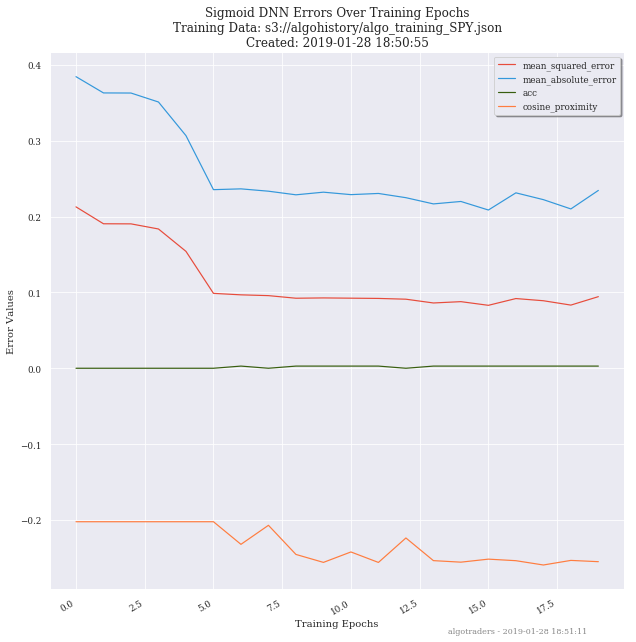

In [20]:
plot_res = plot_fit_history.plot_dnn_fit_history(
    df=sigmoid_history.history,
    title=(
        f'Sigmoid DNN Errors Over Training Epochs\n'
        f'Training Data: s3://{s3_bucket}/{s3_key}\n'
        f'Created: {created_on}'),
    red='mean_squared_error',
    blue='mean_absolute_error',
    green='acc',  # accuracy
    orange='cosine_proximity')

## Run Predictions

### Run Control Predictions

In [21]:
print(
    f'making control predictions: {len(control_predict_records)}')

control_predictions = dnn_control_estimator.model.predict(
    control_predict_records,
    verbose=True)

np.set_printoptions(threshold=np.nan)
indexes = tf.argmax(control_predictions, axis=1)
data = {}
data['indexes'] = indexes
control_price_predictions = [ae_consts.to_f(x[0]) for x in control_predictions]

timeseries_df['control_close'] = control_price_predictions
timeseries_df['control_error'] = (
    timeseries_df['close'] -
    timeseries_df['control_close'])
control_average_error = ae_consts.to_f(
    timeseries_df['control_error'].sum() / len(timeseries_df.index))

print(
    f'Average historical close '
    f'vs control predicted close error: '
    f'{control_average_error}')

making control predictions: 390
390/390 [==============================] - ETA:  - 0s 188us/step
Average historical close vs control predicted close error: -0.03


### Run ReLU Predictions

In [22]:
print(
    f'making relu predictions: {len(predict_records)}')

relu_predictions = dnn_relu_estimator.model.predict(
    predict_records,
    verbose=True)

np.set_printoptions(threshold=np.nan)
indexes = tf.argmax(relu_predictions, axis=1)
data = {}
data['indexes'] = indexes

# inverse the scaled predictions back to floats:
relu_price_predictions = [
    ae_consts.to_f(x) for x in
    scaler_predictions.inverse_transform(
        relu_predictions.reshape(-1, 1)).reshape(-1)]

timeseries_df['relu_close'] = relu_price_predictions
timeseries_df['relu_error'] = (
    timeseries_df['close'] -
    timeseries_df['relu_close'])
relu_average_error = ae_consts.to_f(
    timeseries_df['relu_error'].sum() / len(timeseries_df.index))

print(
    f'Average historical close '
    f'vs relu predicted close error: '
    f'{relu_average_error}')

making relu predictions: 390
390/390 [==============================] - ETA:  - 0s 223us/step
Average historical close vs relu predicted close error: -0.06


### Run Sigmoid Predictions

In [23]:
print(
    f'making sigmoid predictions: {len(predict_records)}')

sigmoid_predictions = dnn_sigmoid_estimator.model.predict(
    predict_records,
    verbose=True)

np.set_printoptions(threshold=np.nan)
indexes = tf.argmax(sigmoid_predictions, axis=1)
data = {}
data['indexes'] = indexes

# inverse the scaled predictions back to floats:
sigmoid_price_predictions = [
    ae_consts.to_f(x) for x in
    scaler_predictions.inverse_transform(
        sigmoid_predictions.reshape(-1, 1)).reshape(-1)]

timeseries_df['sigmoid_close'] = sigmoid_price_predictions
timeseries_df['sigmoid_error'] = (
    timeseries_df['close'] -
    timeseries_df['sigmoid_close'])
sigmoid_average_error = ae_consts.to_f(
    timeseries_df['sigmoid_error'].sum() / len(timeseries_df.index))

print(
    f'Average historical close '
    f'vs sigmoid predicted close error: '
    f'{sigmoid_average_error}')

making sigmoid predictions: 390
390/390 [==============================] - ETA:  - 0s 251us/step
Average historical close vs sigmoid predicted close error: -0.11


## Plot Historical Close vs DNNs' Predicted Close

plotting historical close vs predicted close for control


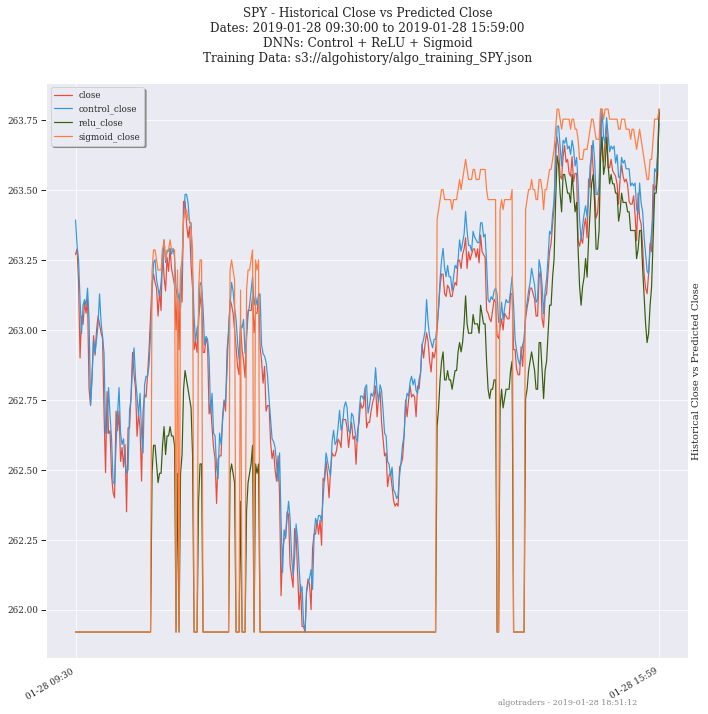

In [24]:
print(
    f'plotting historical close vs predicted close for control')

plot_res = plot_trading_history.plot_trading_history(
    title=(
        f'{ticker} - Historical Close vs Predicted Close\n'
        f'{date_str}\n'
        f'DNNs: Control + ReLU + Sigmoid\n'
        f'Training Data: s3://{s3_bucket}/{s3_key}\n'),
    df=copy.deepcopy(timeseries_df),
    red='close',
    blue='control_close',
    green='relu_close',
    orange='sigmoid_close',
    date_col='minute',
    date_format='%d %H:%M:%S\n%b',
    xlabel='minute',
    ylabel='Historical Close vs Predicted Close',
    df_filter=df_filter,
    width=10.0,
    height=10.0,
    show_plot=True,
    dropna_for_all=False)

### Next Steps: Can you beat the Control dnn's predictions?

Not surprising to see the **control** dnn winning over and over again. With the **close** price bounded between the **high** and **low** training feature values, the **control** neural network's regression predictions using **ReLU** are always more precise to the actual historical **close** price (at least for the **SPY** with this one day of pricing data).

#### So why continue with scaler normalization?

Preprocessing the dataset using scaler normalization ([MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)) resulted in worse regression predictions. The loss of accuracy and precision is hard to justify for regression predictions with this demo dataset and additional scaler normalization processing overhead. For background, scaler normalization in this notebook bounded all the numeric data values between a known float range ([[-1, 1]](https://github.com/AlgoTraders/stock-analysis-engine/blob/master/analysis_engine/ai/build_scaler_dataset_from_df.py#L16) by default) so the dnn could learn from many columns of different data types and values. So while the regression accuracy is hard to compete with, being able to add new, custom columns to a dataset that works with a dnn's **fit** function enables for more feature-rich learning than the control dnn's limited [**high**, **low**, **open**] feature set.

As long as a column can be converted to a float/numeric type the dnn can use it. Getting the weights right appears to be the next challenge (please open an [issue if you know how to fix or improve this](https://github.com/AlgoTraders/stock-analysis-engine/issues/new)). For now, the more indicators and output report variables you add to an indicator, the more features (columns) your trading history dataset will have (and hopefully you can beat the control dnn!).

Finally, why were the scaler normalized **ReLU** DNN's predictions worse than **Sigmoid** DNN's? [It sounds like **ReLU** needs a different preprocessing step than a **MinMaxScaler**.](https://datascience.stackexchange.com/questions/25832/input-normalization-for-relu)

## Considerations, Disclaimers and Legal

- This tool is for educational use to research how dnn's work, data preprocessing, new AI ideas, analysis pipelines of custom datasets, and dnn prediction speed vs prediction quality.
- This notebook is showing just 1 day of pricing data. To keep up with live intraday pricing datafeeds and lots of historical pricing data, you would want to run the rest of the engine's stack (using [docker-compose](https://github.com/AlgoTraders/stock-analysis-engine#running-the-full-stack-locally-for-backtesting-and-live-trading-analysis) or [kubernetes](https://github.com/AlgoTraders/stock-analysis-engine/tree/master/k8)).
- Use this tool at your own risk when trading with your own funds. This is fully open source and there are no promises on how well any of this works with real money. It is still being actively developed and is not for live trading use. If you lose money because "the data said to trade" it's not this tool or its owners', creators' or maintainers' fault. No one involed in this project is responsible or liable for how you use this data. Buyer/seller beware.